In [ ]:
import torch
from torch import nn
import yfinance as yf

In [ ]:
tickers_data = yf.download(["AAPL", "GOOG", "MSFT"], start="2017-01-01", end="2023-12-31")
google_data = yf.download("GOOG", start="2017-01-01", end="2023-12-31")
apple_data = yf.download("AAPL", start="2017-01-01", end="2023-12-31")
microsoft_data = yf.download("MSFT", start="2017-01-01", end="2023-12-31")
print("Historical data for multiple tickers:")
display(tickers_data.head())

/tmp/ipython-input-2392998777.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tickers_data = yf.download(["AAPL", "GOOG", "MSFT"], start="2017-01-01", end="2023-12-31")
[*********************100%***********************]  3 of 3 completed
/tmp/ipython-input-2392998777.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  google_data = yf.download("GOOG", start="2017-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2392998777.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  apple_data = yf.download("AAPL", start="2017-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2392998777.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  microsoft_data = yf.download("MSFT", start="2017-01-01", end="2023-12-31")
[*******************

Historical data for multiple tickers:


Price           Close                             High                        \
Ticker           AAPL       GOOG       MSFT       AAPL       GOOG       MSFT   
Date                                                                           
2017-01-03  26.796839  39.039841  56.404678  26.838366  39.213154  56.639020   
2017-01-04  26.766844  39.077587  56.152317  26.879892  39.298078  56.557912   
2017-01-05  26.902960  39.431164  56.152317  26.960637  39.454006  56.476793   
2017-01-06  27.202881  40.033539  56.639038  27.260558  40.120446  56.918449   
2017-01-09  27.452049  40.058372  56.458763  27.553562  40.223044  56.855347   

Price             Low                             Open                        \
Ticker           AAPL       GOOG       MSFT       AAPL       GOOG       MSFT   
Date                                                                           
2017-01-03  26.476154  38.526356  55.999083  26.716091  38.675831  56.593955   
2017-01-04  26.704553  38.891858  55.990079  26.727624  39.150089  56.314555   
2017-01-05  26.718392  38.984222  55.908960  26.743770  39.036863  56.053171   
2017-01-06  26.870660  39.340978  55.917982  26.942179  39.492741  56.152324   
2017-01-09  27.209806  39.868669  56.368632  27.212112  40.045957  56.566921   

Price          Volume                      
Ticker           AAPL      GOOG      MSFT  
Date                                       
2017-01-03  115127600  33146000  20694100  
2017-01-04   84472400  21460000  21340000  
2017-01-05   88774400  26704000  24876000  
2017-01-06  127007600  32804000  19922900  
2017-01-09  134247600  25492000  20382700

In [ ]:
google_data = google_data.drop(['Close'],axis=1)
google_data

Price,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG
Date,,,,
2017-01-03,39.213154,38.526356,38.675831,33146000
2017-01-04,39.298078,38.891858,39.150089,21460000
2017-01-05,39.454006,38.984222,39.036863,26704000
2017-01-06,40.120446,39.340978,39.492741,32804000
2017-01-09,40.223044,39.868669,40.045957,25492000
...,...,...,...,...
2023-12-22,142.276381,141.089496,141.163998,18513500
2023-12-26,142.966643,141.531457,142.008190,11170100


In [ ]:
google_data.to_excel()

In [ ]:
class LatenConnectedBlock (nn.Module) :
  def __init__ (self,d_model) :
    super().__init__()
    self.step1 = nn.Linear(d_model,d_model)
    self.step2 = nn.Linear(d_model,d_model)
    self.GeLU1 = nn.GELU(approximate='tanh')
    self.GeLU2 = nn.GELU(approximate='tanh')
    self.layernorm = nn.LayerNorm(d_model)
    self.laten_magnitude = nn.Linear(d_model,d_model)
    self.tanh = nn.Tanh()

  def forward(self,x) :
    norm = self.layernorm(x)
    step1 = self.step1(norm)
    step1 = self.GeLU1(step1)
    step2 = self.step2(norm)
    step2 = self.GeLU2(step2)
    laten = step1 + step2
    laten = self.laten_magnitude(laten)
    laten = self.tanh(laten)
    return x + laten

In [ ]:
class LCM (nn.Module) :
  def __init__ (self,num_blocks,d_model) :
    super().__init__()
    self.blocks = nn.ModuleList([LatenConnectedBlock(d_model) for _ in range(num_blocks)])


  def forward(self,x) :
    for block in self.blocks :
      x = block(x)
    return x

In [ ]:
class ForecastModel (nn.Module) :
  def __init__ (self,num_features,d_model) :
    super().__init__()
    self.linear1 = nn.Linear(num_features,d_model)
    self.lcm1 = LCM(num_blocks=3,d_model=d_model)
    self.lcm2 = LCM(num_blocks=3,d_model=d_model)
    self.lcm3 = LCM(num_blocks=3,d_model=d_model)
    self.finish_model= nn.Sequential(
        nn.Linear(d_model,256),
        nn.ReLU(),
        nn.Linear(256,512),
        nn.ReLU(),
        nn.Linear(512,1),
    )



  def forward(self,x) :
    x = self.linear1(x)
    x1 = self.lcm1(x)
    x2 = self.lcm2(x)
    x3 = self.lcm3(x)
    x = x1 + x2 + x3
    x = self.finish_model(x)
    return x


In [ ]:
class UncertaintyWeightLoss(nn.Module):
    def __init__(self, init_log_sigma_cls=0.0, init_log_sigma_reg=0.0):
        super().__init__()
        self.log_sigma_cls = nn.Parameter(torch.tensor(init_log_sigma_cls, dtype=torch.float32))
        self.log_sigma_reg = nn.Parameter(torch.tensor(init_log_sigma_reg, dtype=torch.float32))
        self.bce_loss = nn.BCELoss()
        self.mse_loss = nn.MSELoss()

    def forward(self, y_train_bin, y_train_reg, y_pred_bin, y_pred_reg):
        loss_bin = self.bce_loss(y_pred_bin, y_train_bin)
        loss_reg = self.mse_loss(y_pred_reg, y_train_reg)

        # ini sebenarnya sigma^2
        sigma2_cls = torch.exp(2.0 * self.log_sigma_cls)
        sigma2_reg = torch.exp(2.0 * self.log_sigma_reg)

        # rumus asli (Kendall et al)
        weighted_bin = 0.5 * loss_bin / sigma2_cls + self.log_sigma_cls
        weighted_reg = 0.5 * loss_reg / sigma2_reg + self.log_sigma_reg

        loss_total = weighted_bin + weighted_reg

        return (
            loss_total,
            loss_bin.detach(),
            loss_reg.detach(),
            torch.exp(self.log_sigma_cls).detach(),  # sigma
            torch.exp(self.log_sigma_reg).detach()   # sigma
        )


In [ ]:
x_g = google_data.drop(['Close'],axis=1).values
x_ap = apple_data.drop(['Close'],axis=1).values
x_ms = microsoft_data.drop(['Close'],axis=1).values
y_g = google_data['Close'].values
y_ap = apple_data['Close'].values
y_ms = microsoft_data['Close'].values

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
x_train = np.concatenate((x_g,x_ap,x_ms),axis=0)
y_train = np.concatenate((y_g,y_ap,y_ms),axis=0)


In [ ]:
x_train[:,3] = MinMaxScaler(feature_range=(1,10)).fit_transform(x_train[:,3].reshape(-1,1)).reshape(-1)
x_train

array([[ 39.21315419,  38.5263563 ,  38.67583085,   1.53489311],
       [ 39.29807072,  38.89185023,  39.15008139,   1.29640547],
       [ 39.45400246,  38.98421778,  39.03685894,   1.40342491],
       ...,
       [370.24170692, 368.02061204, 368.88931175,   1.16263934],
       [371.62378772, 369.35334679, 370.54779405,   1.15083537],
       [372.31474384, 368.68202691, 371.1696424 ,   1.24070802]])

In [ ]:
x_train = torch.tensor(x_train,dtype=torch.float32).to('cuda')
y_train = torch.tensor(y_train,dtype=torch.float32).to('cuda')


/tmp/ipython-input-1781223398.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train,dtype=torch.float32).to('cuda')
/tmp/ipython-input-1781223398.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train,dtype=torch.float32).to('cuda')


In [ ]:
subjectmodell1 = ForecastModel(num_features=4,d_model=256)
loss_fn_reg = nn.HuberLoss()
optimizer_fn = torch.optim.AdamW(subjectmodell1.parameters(),lr=0.001)


loss_reg_hits = list()
subjectmodell1.to('cuda')
subjectmodell1.train(True)

ForecastModel(
  (linear1): Linear(in_features=4, out_features=256, bias=True)
  (lcm1): LCM(
    (blocks): ModuleList(
      (0-2): 3 x LatenConnectedBlock(
        (step1): Linear(in_features=256, out_features=256, bias=True)
        (step2): Linear(in_features=256, out_features=256, bias=True)
        (GeLU1): GELU(approximate='tanh')
        (GeLU2): GELU(approximate='tanh')
        (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (laten_magnitude): Linear(in_features=256, out_features=256, bias=True)
        (tanh): Tanh()
      )
    )
  )
  (lcm2): LCM(
    (blocks): ModuleList(
      (0-2): 3 x LatenConnectedBlock(
        (step1): Linear(in_features=256, out_features=256, bias=True)
        (step2): Linear(in_features=256, out_features=256, bias=True)
        (GeLU1): GELU(approximate='tanh')
        (GeLU2): GELU(approximate='tanh')
        (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (laten_magnitude): Linear(in_feature

In [ ]:
optimizer_fn = torch.optim.AdamW(subjectmodell1.parameters(),lr=0.001)


loss_reg_hits = list()
subjectmodell1.to('cuda')
subjectmodell1.train(True)

ForecastModel(
  (linear1): Linear(in_features=4, out_features=256, bias=True)
  (lcm1): LCM(
    (blocks): ModuleList(
      (0-2): 3 x LatenConnectedBlock(
        (step1): Linear(in_features=256, out_features=256, bias=True)
        (step2): Linear(in_features=256, out_features=256, bias=True)
        (GeLU1): GELU(approximate='tanh')
        (GeLU2): GELU(approximate='tanh')
        (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (laten_magnitude): Linear(in_features=256, out_features=256, bias=True)
        (tanh): Tanh()
      )
    )
  )
  (lcm2): LCM(
    (blocks): ModuleList(
      (0-2): 3 x LatenConnectedBlock(
        (step1): Linear(in_features=256, out_features=256, bias=True)
        (step2): Linear(in_features=256, out_features=256, bias=True)
        (GeLU1): GELU(approximate='tanh')
        (GeLU2): GELU(approximate='tanh')
        (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (laten_magnitude): Linear(in_feature

In [ ]:
epochs = 100
for epoch in range(epochs) :
  y_pred = subjectmodell1(x_train)

  loss_reg = loss_fn_reg(y_pred,y_train)
  optimizer_fn.zero_grad()
  loss_reg.backward()
  optimizer_fn.step()
  loss_reg_hits.append(loss_reg.item())
  if loss_reg.item() <= 0.3:
    break
  print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_reg.item():.6f}")

Epoch 1/100, Loss: 0.484719
Epoch 2/100, Loss: 0.507919
Epoch 3/100, Loss: 0.484666
Epoch 4/100, Loss: 0.507213
Epoch 5/100, Loss: 0.483960
Epoch 6/100, Loss: 0.506748
Epoch 7/100, Loss: 0.484044
Epoch 8/100, Loss: 0.507126
Epoch 9/100, Loss: 0.484149
Epoch 10/100, Loss: 0.506772
Epoch 11/100, Loss: 0.483598
Epoch 12/100, Loss: 0.506201
Epoch 13/100, Loss: 0.483450
Epoch 14/100, Loss: 0.506366
Epoch 15/100, Loss: 0.483575
Epoch 16/100, Loss: 0.506224
Epoch 17/100, Loss: 0.483186
Epoch 18/100, Loss: 0.505679
Epoch 19/100, Loss: 0.482911
Epoch 20/100, Loss: 0.505650
Epoch 21/100, Loss: 0.482983
Epoch 22/100, Loss: 0.505620
Epoch 23/100, Loss: 0.482747
Epoch 24/100, Loss: 0.505182
Epoch 25/100, Loss: 0.482426
Epoch 26/100, Loss: 0.504993
Epoch 27/100, Loss: 0.482405
Epoch 28/100, Loss: 0.504981
Epoch 29/100, Loss: 0.482264
Epoch 30/100, Loss: 0.504652
Epoch 31/100, Loss: 0.481950
Epoch 32/100, Loss: 0.504375
Epoch 33/100, Loss: 0.481843
Epoch 34/100, Loss: 0.504330
Epoch 35/100, Loss: 0.4

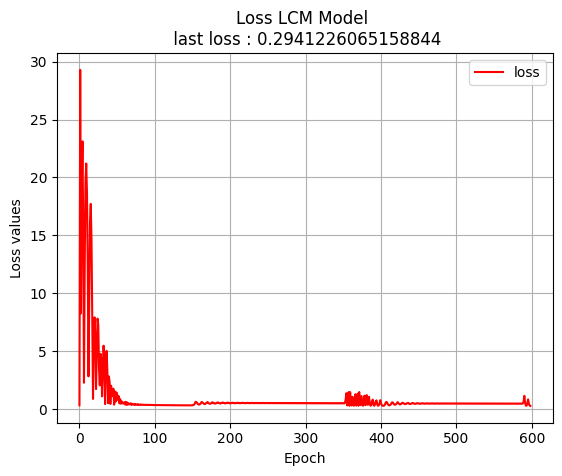

In [ ]:
import matplotlib.pyplot as plt
plt.title(f"Loss LCM Model \n last loss : {loss_reg_hits[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss values" )
plt.plot(loss_reg_hits,label='loss',color='red')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error,explained_variance_score

In [ ]:
subjectmodell1.to('cpu')
subjectmodell1.eval()
torch.save(subjectmodell1.state_dict(),'LCMForecast2.pth')

In [ ]:
x_train =x_train.to('cpu')
y_train = y_train.to('cpu')

In [ ]:
y_pred = subjectmodell1(x_train)
y_pred = y_pred.detach().numpy()

In [ ]:
mse_loss = mean_squared_error(y_train,y_pred)
mae_loss = mean_absolute_error(y_train,y_pred)
r2_loss = r2_score(y_train,y_pred)
mape_loss = mean_absolute_percentage_error(y_train,y_pred)

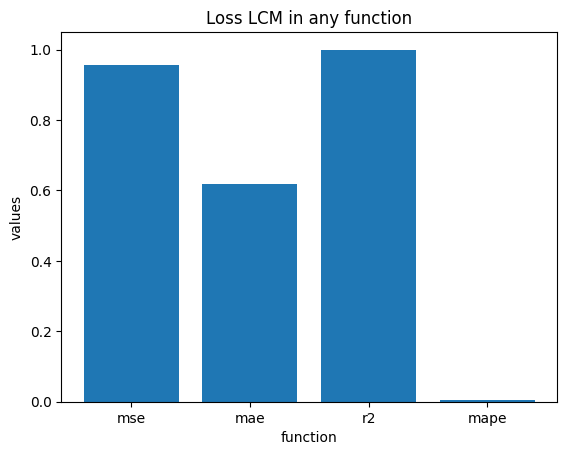

In [ ]:
plt.title("Loss LCM in any function")
plt.ylabel("values")
plt.xlabel("function")
plt.bar(['mse','mae','r2','mape'],[mse_loss,mae_loss,r2_loss,mape_loss])
plt.show()

In [ ]:
mae_loss

0.6183618903160095